This notebook aims to instill the flexibility of MCGLM alongside its comprehensive list of viable analyses.

In [173]:
import sys, os
sys.path.append(os.path.join(sys.path[0],'..'))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mcglm import MCGLM, mc_mixed, mc_id, mc_ma
from patsy import dmatrix
from statsmodels.tools.tools import add_constant

import warnings
warnings.simplefilter("ignore")

The statistical framework Multivariate Covariance Generalized Linear Models(MCGLM) provides a unified model for fitting in a wide variety of data such as gaussian or non-gaussian, univariate or multivariate, dependent or independent. This pliability comes from the second-moment assumptions and the straightforward yet thorough specification of pivotal model components. The specification of five components tuns the MCGLM framework: linear predictor/design matrix, link function, variance function, covariance function, and dependencies matrices Z. 

The Python library mcglm provides an easy interface for fitting the MCGLM model, similar to the library statsmodels, providing auxiliary methods to lead a proper specification of each MCGLM component. The library provides a comprehensive report for the model fitting analysis with regression parameters, dispersion parameters, confidence intervals, hypothesis testing, and Pearson residue. As yet, only users of R users have access to the MCGLM algorithm by the package mcglm. 

Finally, this notebook presents some statistical analysis with the support of Python mcglm.

Refs: 

https://www.jstor.org/stable/44681850    
https://www.researchgate.net/publication/324579147_Multiple_Response_Variables_Regression_Models_in_R_The_mcglm_Package    

In [2]:
print(MCGLM.__doc__)


        MCGLM class that implements MCGLM algorithm. (Bonat, Jørgensen 2015)
        
        It extends GLM for multi-responses and dependent components by fitting second-moment adjustment.

        Args:
            endog : array_like
                1d array of endogenous response variable. In case of multiple responses, the user must pass the responses on a list.  
            exog : array_like
                A dataset with the endogenous matrix in a Numpy fashion. Since the library doesn't set an intercept by default, the user must add it. In the case of multiple responses, the user must pass the design matrices as a python list. 
            z : array_like
                List with matrices components of the linear covariance matrix.
            link : array_like, string or None
                Specification for the link function. The MCGLM library implements the following options: identity, logit, power, log, probit, cauchy, cloglog, loglog, negativebinomial. In the case of No

The MCGLM framework behaves conditioned by the link and variance function. As this doc aims to demonstrate some of them. Let's get started with the first one: the ordinary least squares linear regression.

#### Linear Regression   

-------------

Perhaps the most popular statistical model, Linear Regression is a great choice when data meets the three assumptions:   

1. Linearity.   
2. Independence of components Y. a.k.a iid.   
3. The distribution of error following a Gaussian with tuple (0, dispersion).    


 
Boston dataset will set the basis for this analysis.

In [28]:
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)
X = pd.DataFrame(X)
y = pd.Series(y, name='output')

In [29]:
y.describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: output, dtype: float64

In [30]:
modelresults = MCGLM(endog=y,
                     exog=X,
                     z=[mc_id(X)]).fit()
modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                 output   No. Iterations:                      9
Model:                          MCGLM   No. Observations:                  506
link:                        identity   Df Residuals:                      492
variance:                    constant   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 04 Aug 2022   pAIC                           2569.58
Time:                        07:56:30   pBIC                           2628.75
                                        pLogLik                     -1270.7905
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0929      0.034     -2.734      0.006      -0.159      -0.026
1              0.0487      0.014      3.426      0.001       0.021       0.077
2             -0.0041      0.064     -0.064      0.949      -0.129       0.121
3              2.8540      0.892      3.199      0.001       1.105       4.603
4             -2.8684      3.315     -0.865      0.387      -9.366       3.630
5              5.9281      0.305     19.429      0.000       5.330       6.526
6             -0.0073      0.014     -0.533      0.594      -0.034       0.019
7             -0.9685      0.193     -5.015      0.000      -1.347      -0.590
8              0.1712      0.066      2.597      0.009       0.042       0.300
9             -0.0094      0.004     -2.426      0.015      -0.017      -0.002
10            -0.3922      0.108     -3.616      0.000      -0.605      -0.180
11             0.0149      0.003      5.600      0.000       0.010       0.020
12            -0.4163      0.050     -8.304      0.000      -0.515      -0.318
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1    24.1670      3.308      7.305      0.000      17.683      30.651
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

Text(0, 0.5, 'pearson residue')

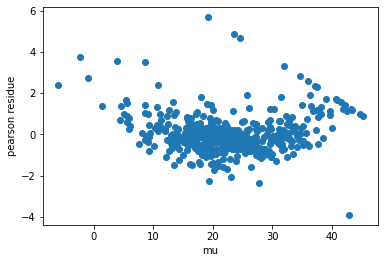

In [31]:
# Residual Analysis
plt.scatter(modelresults.mu, modelresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residuals")

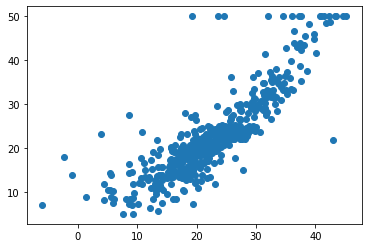

In [32]:
plt.scatter(modelresults.mu, y)

#### Generalized Linear Model   
---
Gamma Linear Model

In [49]:
modelresults = MCGLM(y, 
                     X, 
                     [mc_id(X)], 
                     link='log', 
                     variance='tweedie', 
                     power=2, 
                     power_fixed=True, 
                     tuning=0.05
                     ).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                 output   No. Iterations:                     49
Model:                          MCGLM   No. Observations:                  506
link:                             log   Df Residuals:                      492
variance:                     tweedie   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 04 Aug 2022   pAIC                           3235.15
Time:                        08:07:47   pBIC                           3294.32
                                        pLogLik                     -1603.5758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0078      0.003     -2.529      0.011      -0.014      -0.002
1              0.0020      0.001      1.526      0.127      -0.001       0.004
2             -0.0013      0.006     -0.227      0.820      -0.013       0.010
3              0.1339      0.081      1.660      0.097      -0.024       0.292
4              0.9172      0.300      3.060      0.002       0.330       1.505
5              0.3103      0.028     11.247      0.000       0.256       0.364
6             -0.0001      0.001     -0.115      0.908      -0.003       0.002
7              0.0036      0.017      0.205      0.838      -0.031       0.038
8              0.0007      0.006      0.125      0.901      -0.011       0.012
9             -0.0003      0.000     -0.725      0.468      -0.001       0.000
10             0.0305      0.010      3.114      0.002       0.011       0.050
11             0.0010      0.000      4.358      0.000       0.001       0.002
12            -0.0183      0.005     -4.038      0.000      -0.027      -0.009
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     0.1920      0.015     12.456      0.000       0.162       0.222
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         2.0000        nan        nan        nan         nan         nan
==============================================================================
"""

Text(0, 0.5, 'pearson residuals')

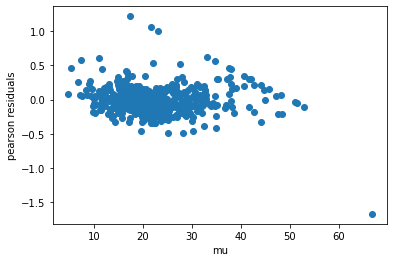

In [50]:
# Residual Analysis
plt.scatter(modelresults.mu, modelresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residuals")

In [59]:
modelresults = MCGLM(y, 
                     X, 
                     [mc_id(X)], 
                     link='log', 
                     variance='tweedie', 
                     power=2, 
                     power_fixed=False, 
                     tuning=0.05
                     ).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                 output   No. Iterations:                     49
Model:                          MCGLM   No. Observations:                  506
link:                             log   Df Residuals:                      492
variance:                     tweedie   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                     False
Date:                Thu, 04 Aug 2022   pAIC                           4288.16
Time:                        08:09:52   pBIC                           4347.33
                                        pLogLik                     -2130.0805
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0078      0.009     -0.893      0.372      -0.025       0.009
1              0.0020      0.004      0.539      0.590      -0.005       0.009
2             -0.0013      0.016     -0.080      0.936      -0.033       0.031
3              0.1339      0.228      0.587      0.558      -0.314       0.581
4              0.9172      0.848      1.081      0.280      -0.746       2.580
5              0.3103      0.078      3.973      0.000       0.157       0.463
6             -0.0001      0.003     -0.041      0.968      -0.007       0.007
7              0.0036      0.049      0.072      0.942      -0.093       0.100
8              0.0007      0.017      0.044      0.965      -0.032       0.034
9             -0.0003      0.001     -0.256      0.798      -0.002       0.002
10             0.0305      0.028      1.100      0.271      -0.024       0.085
11             0.0010      0.001      1.540      0.124      -0.000       0.002
12            -0.0183      0.013     -1.426      0.154      -0.043       0.007
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1    -0.4720      0.393     -1.203      0.229      -1.241       0.297
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.5733      0.083     18.873      0.000       1.410       1.737
==============================================================================
"""

Text(0, 0.5, 'pearson residuals')

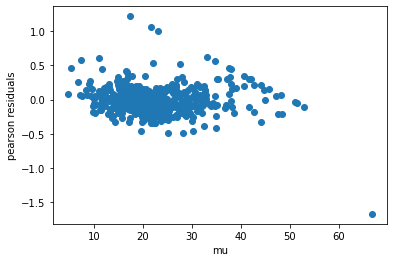

In [60]:
# Residual Analysis
plt.scatter(modelresults.mu, modelresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residuals")

#### Generalized Linear Model   
---
Poisson Linear Model

In [56]:
# https://www.kaggle.com/datasets/gregorut/videogamesales
## Game Sales in millions

vgdata = pd.read_csv('data/vgsales.csv')
vgdata = vgdata[['Publisher', 'Genre', 'Year', 'Global_Sales']] # keeping the valuable columns
vgdata = vgdata[~vgdata.isnull()] # filtering out nulls
vgdata = vgdata[vgdata.Publisher.isin(['Electronic Arts', 'Activision', 'Namco Bandai Games', 'Ubisoft', 'Konami Digital Entertainment', 'THQ', 'Nintendo'])].reset_index(drop=True)# Keeping the meaninfull publishers

### Setting type
vgdata['Publisher'] = vgdata['Publisher'].astype('str')
vgdata['Genre'] = vgdata['Genre'].astype('str')

vgdata = vgdata[vgdata.Year > 1980]
vgdata = vgdata.sample(1000).reset_index(drop=True)

## exog and endog
X = vgdata[['Publisher', 'Year', 'Genre']]
y = vgdata['Global_Sales']

X = pd.get_dummies(X)

In [63]:
modelresults = MCGLM(y, 
                     X, 
                     [mc_id(X)], 
                     ).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:           Global_Sales   No. Iterations:                     13
Model:                          MCGLM   No. Observations:                 1000
link:                        identity   Df Residuals:                      979
variance:                    constant   Df Model:                           21
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 04 Aug 2022   pAIC                            3011.6
Time:                        12:44:02   pBIC                           3114.67
                                        pLogLik                     -1484.8018
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Year                                      -0.0090      0.014     -0.629      0.530      -0.037       0.019
Publisher_Activision                      11.6002   1.95e+06   5.95e-06      1.000   -3.82e+06    3.82e+06
Publisher_Electronic Arts                 11.8099   2.05e+06   5.76e-06      1.000   -4.02e+06    4.02e+06
Publisher_Konami Digital Entertainment    11.3344   2.03e+06   5.59e-06      1.000   -3.97e+06    3.97e+06
Publisher_Namco Bandai Games              11.3986   1.95e+06   5.84e-06      1.000   -3.82e+06    3.82e+06
Publisher_Nintendo                        13.7296   1.97e+06   6.96e-06      1.000   -3.87e+06    3.87e+06
Publisher_THQ                             11.6849   1.96e+06   5.96e-06      1.000   -3.84e+06    3.84e+06
Publisher_Ubisoft                         11.8090   2.05e+06   5.76e-06      1.000   -4.02e+06    4.02e+06
Genre_Action                               6.8781   1.94e+06   3.54e-06      1.000    -3.8e+06     3.8e+06
Genre_Adventure                            6.7147   1.95e+06   3.44e-06      1.000   -3.83e+06    3.83e+06
Genre_Fighting                             7.0634   1.99e+06   3.55e-06      1.000    -3.9e+06     3.9e+06
Genre_Misc                                 7.2270   2.03e+06   3.56e-06      1.000   -3.98e+06    3.98e+06
Genre_Platform                             7.1722   2.14e+06   3.35e-06      1.000   -4.19e+06    4.19e+06
Genre_Puzzle                               5.9755   2.02e+06   2.96e-06      1.000   -3.96e+06    3.96e+06
Genre_Racing                               6.9142   2.03e+06    3.4e-06      1.000   -3.99e+06    3.99e+06
Genre_Role-Playing                         6.9669   2.14e+06   3.26e-06      1.000   -4.19e+06    4.19e+06
Genre_Shooter                              7.5295   1.99e+06   3.79e-06      1.000    -3.9e+06     3.9e+06
Genre_Simulation                           6.8664   1.99e+06   3.45e-06      1.000   -3.91e+06    3.91e+06
Genre_Sports                               7.3109   2.01e+06   3.64e-06      1.000   -3.93e+06    3.93e+06
Genre_Strategy                             6.7795    2.1e+06   3.22e-06      1.000   -4.12e+06    4.12e+06
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     3.1010      0.754      4.115      0.000       1.624       4.578
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
=============================================================

Text(0, 0.5, 'pearson residue')

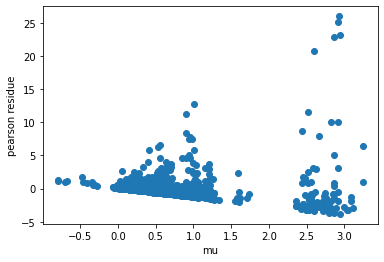

In [64]:
# Residual Analysis
plt.scatter(modelresults.mu, modelresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residue")

In [65]:
modelresults = MCGLM(y, 
                     X, 
                     [mc_id(X)], 
                     link='log', 
                     variance='tweedie', 
                     power=2, 
                     power_fixed=False, 
                     tuning=0.05
                     ).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:           Global_Sales   No. Iterations:                     49
Model:                          MCGLM   No. Observations:                 1000
link:                             log   Df Residuals:                      979
variance:                     tweedie   Df Model:                           21
Method:              Quasi-Likelihood   Power-fixed:                     False
Date:                Thu, 04 Aug 2022   pAIC                           1696.13
Time:                        12:48:35   pBIC                           1799.19
                                        pLogLik                       -827.065
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Year                                      -0.0168      0.045     -0.374      0.709      -0.105       0.071
Publisher_Activision                      18.9656   7.89e+06    2.4e-06      1.000   -1.55e+07    1.55e+07
Publisher_Electronic Arts                 19.3968    3.3e+06   5.88e-06      1.000   -6.46e+06    6.46e+06
Publisher_Konami Digital Entertainment    18.4784   5.41e+06   3.42e-06      1.000   -1.06e+07    1.06e+07
Publisher_Namco Bandai Games              18.2468   5.14e+06   3.55e-06      1.000   -1.01e+07    1.01e+07
Publisher_Nintendo                        20.5703    7.3e+06   2.82e-06      1.000   -1.43e+07    1.43e+07
Publisher_THQ                             19.0984   7.44e+06   2.57e-06      1.000   -1.46e+07    1.46e+07
Publisher_Ubisoft                         19.3827   6.52e+06   2.97e-06      1.000   -1.28e+07    1.28e+07
Genre_Action                              13.9379   8.93e+06   1.56e-06      1.000   -1.75e+07    1.75e+07
Genre_Adventure                           13.5300   7.59e+06   1.78e-06      1.000   -1.49e+07    1.49e+07
Genre_Fighting                            14.4637   6.12e+06   2.36e-06      1.000    -1.2e+07     1.2e+07
Genre_Misc                                14.3009   7.24e+06   1.98e-06      1.000   -1.42e+07    1.42e+07
Genre_Platform                            13.9890   7.66e+06   1.83e-06      1.000    -1.5e+07     1.5e+07
Genre_Puzzle                              13.2127   6.01e+06    2.2e-06      1.000   -1.18e+07    1.18e+07
Genre_Racing                              13.9939   5.19e+06    2.7e-06      1.000   -1.02e+07    1.02e+07
Genre_Role-Playing                        14.3604   7.15e+06   2.01e-06      1.000    -1.4e+07     1.4e+07
Genre_Shooter                             14.7638    4.3e+06   3.44e-06      1.000   -8.42e+06    8.42e+06
Genre_Simulation                          13.8659   6.75e+06   2.05e-06      1.000   -1.32e+07    1.32e+07
Genre_Sports                              14.3919   4.41e+06   3.26e-06      1.000   -8.64e+06    8.64e+06
Genre_Strategy                            13.8607    7.9e+06   1.75e-06      1.000   -1.55e+07    1.55e+07
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     2.5250      0.356      7.100      0.000       1.828       3.222
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         2.3617      0.138     17.063      0.000       2.090       2.633
=============================================================

Text(0, 0.5, 'pearson residue')

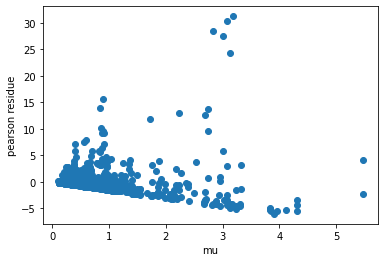

In [66]:
# Residual Analysis
plt.scatter(modelresults.mu, modelresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residue")

#### Generalized Linear Model   
---
Binomial Linear Model

In [91]:
titanic = pd.read_csv('data/titanic.csv')

In [130]:
y = titanic['Survived']

#X = titanic[['Fare', 'SibSp',  'Embarked', 'Parch', 'Pclass', 'Sex']]
X = titanic[['Fare', 'SibSp',  'Embarked', 'Parch', 'Pclass']]
X = X.fillna('S')
           

X = pd.get_dummies(X)

In [132]:
modelresults = MCGLM(y, 
                     X, 
                     [mc_id(X)],
                     link='cloglog',
                     variance='binomialP',
                     ntrial=1,
                     tuning=0.05
                     ).fit()
modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:               Survived   No. Iterations:                      0
Model:                          MCGLM   No. Observations:                  891
link:                         cloglog   Df Residuals:                      883
variance:                   binomialP   Df Model:                            8
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 04 Aug 2022   pAIC                            230.34
Time:                        14:39:26   pBIC                            268.68
                                        pLogLik                      -107.1682
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Fare           0.0015      0.001      1.311      0.190      -0.001       0.004
SibSp         -0.0615      0.063     -0.973      0.330      -0.185       0.062
Parch          0.1802      0.071      2.547      0.011       0.042       0.319
Pclass        -0.5829      0.080     -7.293      0.000      -0.740      -0.426
Embarked_C     0.6777      0.211      3.206      0.001       0.263       1.092
Embarked_Q     0.9306      0.299      3.115      0.002       0.345       1.516
Embarked_S     0.3405      0.195      1.749      0.080      -0.041       0.722
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     1.0000      0.034     29.731      0.000       0.934       1.066
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

Text(0, 0.5, 'pearson residue')

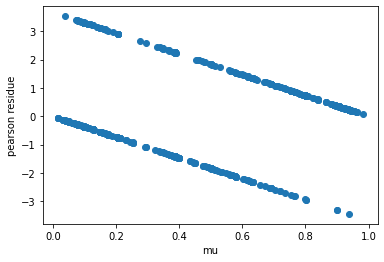

In [120]:
# Residual Analysis
plt.scatter(modelresults.mu, modelresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residue")

In [137]:
## Evaluating multiple links
modelresults_logit = MCGLM(y, X, [mc_id(X)], link='logit', variance='binomialP', ntrial=1, tuning=0.05).fit()

modelresults_loglog = MCGLM(y, X, [mc_id(X)], link='loglog', variance='binomialP', ntrial=1, tuning=0.05).fit()

modelresults_cloglog = MCGLM(y, X, [mc_id(X)], link='cloglog', variance='binomialP', ntrial=1, tuning=0.15).fit()

modelresults_cauchy = MCGLM(y, X, [mc_id(X)], link='cauchy', variance='binomialP', ntrial=1, tuning=0.15).fit()

In [138]:
print('logit_aic: ', modelresults_logit.aic, 
      ', loglog_aic: ', modelresults_loglog.aic,
      ', cloglog_aic: ', modelresults_cloglog.aic,
      ', cauchy_aic: ', modelresults_cauchy.aic)

logit_aic:  213.8 , loglog_aic:  196.88 , cloglog_aic:  228.19 , cauchy_aic:  221.24


Text(0, 0.5, 'pearson residue')

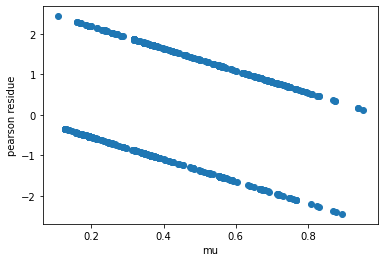

In [139]:
# Residual Analysis
plt.scatter(modelresults_loglog.mu, modelresults_loglog.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residue")

### Dependence section

Moving Averages model

In [148]:
import statsmodels.api as sm

dta = sm.datasets.sunspots.load_pandas().data

X = add_constant(dta[['YEAR']])
y = dta['SUNACTIVITY']

<AxesSubplot:xlabel='YEAR', ylabel='SUNACTIVITY'>

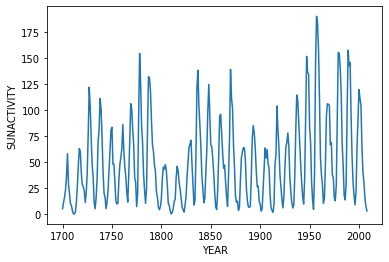

In [168]:
sns.lineplot(dta['YEAR'], dta['SUNACTIVITY'])

A great way to define the MA is by the ACF graph. Points outside the CI interval.

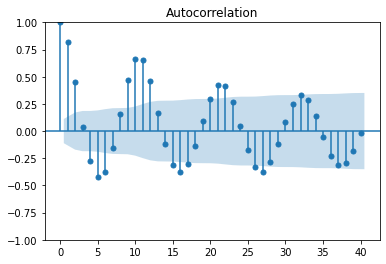

In [165]:
sm.graphics.tsa.plot_acf(dta['SUNACTIVITY'].squeeze(), lags=40)
plt.show()

We might add moving averages: 1, 2, 4, 5 e 6.

In [169]:
modelresults = MCGLM(y, 
                     X, 
                     [mc_id(X), 
                      mc_ma(id='const', time='YEAR', data=X, order=1), 
                      mc_ma(id='const', time='YEAR', data=X, order=2), 
                      mc_ma(id='const', time='YEAR', data=X, order=4),
                      mc_ma(id='const', time='YEAR', data=X, order=5),
                      mc_ma(id='const', time='YEAR', data=X, order=6)
                      ]
                     ).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:            SUNACTIVITY   No. Iterations:                     29
Model:                          MCGLM   No. Observations:                  309
link:                        identity   Df Residuals:                      301
variance:                    constant   Df Model:                            8
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Mon, 08 Aug 2022   pAIC                           2338.73
Time:                        19:34:18   pBIC                            2368.6
                                        pLogLik                     -1161.3656
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -131.8554     67.762     -1.946      0.052    -264.667       0.956
YEAR           0.0978      0.037      2.680      0.007       0.026       0.169
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1  1280.5530    161.496      7.929      0.000     964.027    1597.079
dispersion_2   997.4170    119.756      8.329      0.000     762.699    1232.135
dispersion_3   465.2660     56.893      8.178      0.000     353.757     576.775
dispersion_4  -201.9190     26.457     -7.632      0.000    -253.773    -150.065
dispersion_5  -177.6790     22.804     -7.792      0.000    -222.373    -132.985
dispersion_6   -65.7750      9.820     -6.698      0.000     -85.023     -46.527
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

The dispersion parameters show the error correction values specified on the model parameter.

#### Mixed Models

---------

In [170]:
# Top 10 cells to get an intuition about data.
sleepstudy = pd.read_csv("data/first_simulation/sleepstudy.csv", dtype={"Subject": "str"})

sleepstudy.head(10)

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
5,414.6901,5,308
6,382.2038,6,308
7,290.1486,7,308
8,430.5853,8,308
9,466.3535,9,308


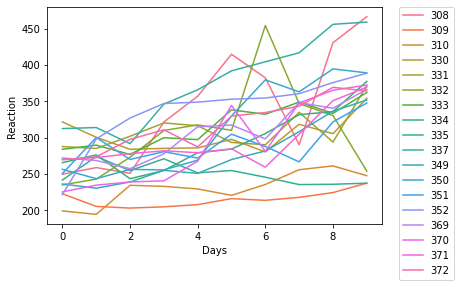

In [171]:
## Plotting curve of 18 subjects
_ = sns.lineplot(x="Days", y="Reaction", hue="Subject", data=sleepstudy)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [174]:
# Design Matrix
X = dmatrix("~ Days", sleepstudy, return_type="dataframe")

# Z specification
Z = [mc_id(sleepstudy)] + mc_mixed(formula="~ 0 + Subject / Days", data=sleepstudy)

In [175]:
# Model fitting
mcglm = MCGLM(endog=sleepstudy["Reaction"], exog=X, z=Z)

mcglmresults = mcglm.fit()

In [176]:
mcglmresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:               Reaction   No. Iterations:                     20
Model:                          MCGLM   No. Observations:                  180
link:                        identity   Df Residuals:                      174
variance:                    constant   Df Model:                            6
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Mon, 08 Aug 2022   pAIC                           1583.94
Time:                        19:45:56   pBIC                            1603.1
                                        pLogLik                      -785.9704
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    251.4051      6.632     37.906      0.000     238.406     264.404
Days          10.4673      1.502      6.968      0.000       7.523      13.412
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1   654.9420     70.624      9.274      0.000     516.521     793.363
dispersion_2   565.5150    264.679      2.137      0.033      46.753    1084.277
dispersion_3    32.6820     13.560      2.410      0.016       6.105      59.259
dispersion_4    11.0550     42.948      0.257      0.797     -73.121      95.231
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

#### Beta coefficients  
The Beta section diagnose the fixed-effects parameters, that is to say, the conclusion overall subjects.  

    Intercept set at value 251.40. The straightforward takeaway is: At day 0, the average response time is roughly 251 seconds.
    In addition, Days at 10.46 allude to total change to response time by unit changes on Days, for subjects with random effects set to 0.
    Furthermore, by the results of the wald test on Days, we might conclude that days are statistically significant in the statistical model.
---
#### Dispersion parameters   
The Dispersion parameters allude to random effects within individuals throughout the days.  

    The first dispersion parameter is the variance across all data points. Calculated in 654.94.
    The second dispersion parameter is the variance across all intercepts, which is 565.51.
    The third dispersion parameter is the variance across all slopes. Calculated in 32.68. 
    The fourth dispersion parameter is the variance across intercepts and slopes. Calculated in 11.05.

* Moreover, the correlation might be calculated through the formula = dispersion_4/(sqrt(dispersion_2) + sqrt(dispersion_3)). Cell below shows the pearson correlation result, 0.37.   

### Soya

`Soya` is a dataset that stores an experiment of Universidade Federal da Grande Dourados in Dourados, Mato Grosso do Sul, Brazil. Description:    
https://github.com/walmes/wzRfun/blob/master/R/wzRfun.R#L10   
http://ccarevista.ufc.br/seer/index.php/ccarevista/article/view/1454  

The experiment collected data about different treatments of `potassium`, `water`, and `blocks` for soil farming on buckets. All of those covariates are categorical. The response traits to be analyzed are: `grain size`, `total seeds`, and `viable peas`, which stands for the weight of hundred grains, total grain per bucket, and percentage of viable peas(green beans). In the following, MCGLM fits onto this data with three unique kinds of answers: continuous, count, and binomial.

In [177]:
soya = pd.read_csv(
    "data/fourth_simulation/soya.csv", dtype={"block": "str", "water": "str", "pot": "str"}
)

soya["viablegrain"] = soya["viablepeas"] / soya["totalpeas"]

In [178]:
# percentual of peas.
soya["viablePeas"] = soya["viablepeas"] / soya["totalpeas"]

# Design matrix.
X = dmatrix("~ block + water * pot", soya, return_type="dataframe")

In [179]:
# Model Specification
mcglm = MCGLM(
    endog=[soya["grain"], soya["seeds"], soya["viablePeas"]],
    exog=[X, X, X],
    z=[[mc_id(soya)], [mc_id(soya)], [mc_id(soya)]],
    link=["identity", "log", "logit"],
    variance=["constant", "tweedie", "binomialP"],
    ntrial=[None, None, soya["totalpeas"].values],
)


mcglmresults = mcglm.fit()

In [180]:
mcglmresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                  grain   No. Iterations:                     10
Model:                          MCGLM   No. Observations:                   75
link:                        identity   Df Residuals:                       55
variance:                    constant   Df Model:                           20
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Mon, 08 Aug 2022   pAIC                            448.21
Time:                        19:54:33   pBIC                            516.53
                                        pLogLik                      -204.1064
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   14.2456      1.218     11.699      0.000      11.859      16.632
block[T.II]                  1.1324      0.880      1.286      0.198      -0.593       2.858
block[T.III]                -0.7801      0.880     -0.886      0.376      -2.506       0.946
block[T.IV]                 -1.5492      0.880     -1.760      0.078      -3.275       0.176
block[T.V]                  -2.3871      0.880     -2.711      0.007      -4.113      -0.661
water[T.50]                  2.1661      1.531      1.415      0.157      -0.835       5.167
water[T.62.5]                2.5404      1.531      1.659      0.097      -0.460       5.541
pot[T.120]                  11.7898      1.531      7.701      0.000       8.789      14.790
pot[T.180]                  11.8633      1.531      7.749      0.000       8.863      14.864
pot[T.30]                    6.7895      1.531      4.435      0.000       3.789       9.790
pot[T.60]                   10.3978      1.531      6.792      0.000       7.397      13.399
water[T.50]:pot[T.120]       2.2543      2.165      1.041      0.298      -1.989       6.498
water[T.62.5]:pot[T.120]     5.5828      2.165      2.578      0.010       1.339       9.826
water[T.50]:pot[T.180]       1.2096      2.165      0.559      0.576      -3.034       5.453
water[T.62.5]:pot[T.180]     9.2389      2.165      4.267      0.000       4.995      13.483
water[T.50]:pot[T.30]        0.1067      2.165      0.049      0.961      -4.137       4.350
water[T.62.5]:pot[T.30]     -1.8678      2.165     -0.863      0.388      -6.112       2.376
water[T.50]:pot[T.60]        2.6034      2.165      1.202      0.229      -1.640       6.847
water[T.62.5]:pot[T.60]      3.3586      2.165      1.551      0.121      -0.885       7.602
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     5.8620      1.671      3.508      0.000       2.587       9.137
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                  seeds   No. Iterations:                     10
Model:                          MCGLM   No. Observations:                   75
link:                             log   Df Residuals:                       55
variance:                     tweedie   Df Model:                           20
Me

The three responses have generated a three-section report. As it follows, a analysis per response.

---
`grain` size.

The grain response was fitted with default parameters, `identity` and `constant`, generating a near homoscedastic linear model. Among covariates `block`, `water` and `potassium`, by Wald test, potassium levels are statistically significant for the model; the higher potassium level, bigger grain size. Variance constant on 5.862.   

Residual analysis:

Text(0, 0.5, 'pearson residual')

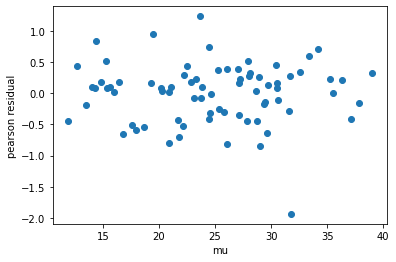

In [181]:
# grain. residual analysis
plt.scatter(mcglmresults.mu[0], mcglmresults.pearson_residuals[0])
plt.xlabel("mu")
plt.ylabel("pearson residual")

Despite the outlier, the fit seems pretty good.

---
`seed` count.

As long as seed is a count variable, a straightforward and canonical way to model it is Poisson. Two out of three covariates are statistically significant on `seed`: potassium, for every level; and black for level V.

Residual analysis:

Text(0, 0.5, 'pearson residual')

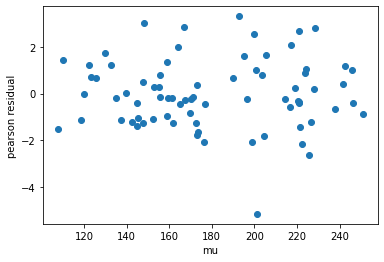

In [182]:
# seeds. residual analysis
plt.scatter(mcglmresults.mu[1], mcglmresults.pearson_residuals[1])
plt.xlabel("mu")
plt.ylabel("pearson residual")

Notwithstanding the outlier, the fit seems pretty good.

---
Percentage of `viable peas`.

Binomial N trials is the adequate model for bounded data. Perhaps, the most popular solution to fit is the `Logit` link, the one used. Among covariates, only potassium level 30, and water level 50 are statistically significant with Viable Peas.

Residual Analysis:

Text(0, 0.5, 'pearson residual')

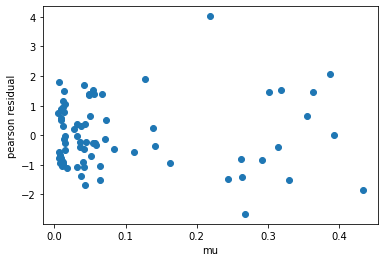

In [183]:
# viablepeasP. residual analysis
plt.scatter(mcglmresults.mu[2], mcglmresults.pearson_residuals[2])
plt.xlabel("mu")
plt.ylabel("pearson residual")

The model has not fitted well. It is possible to try out different values for link and variance functions. Suppose it does not improve the model fit. In that case, it will let us conclude a non-assessment for the percentage of viable peas from current covariates.   

The last three components rhos allude to the correlation coefficient among responses. 
 * rho_1 stands for grain size and whole seeds, with a considerable Pearson correlation of 0.63.
 * rho_2 and rho_3 stand for correlation between grain size and viable peas, seed count, and viable peas, respectively. Both correlations are low. 